In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd drive/My\ Drive/cs5224_project

/content/drive/My Drive/cs5224_project


In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import array
import numpy as np
import pandas as pd
import gzip
import urllib
import pickle

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import VGG16
from keras import models
from keras import layers
from keras import optimizers
from keras.utils import to_categorical
from keras.models import load_model

Using TensorFlow backend.


In [0]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [0]:
# read data inputs from http://jmcauley.ucsd.edu/data/amazon/links.html 5-core Video Games
df_product = getDF('meta_Video_Games.json.gz')
df_reviews = getDF('reviews_Video_Games.json.gz')

In [0]:
df_reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AB9S9279OZ3QO,0078764343,Alan,"[1, 1]",I haven't gotten around to playing the campaig...,5.0,Good game and Beta access!!,1373155200,"07 7, 2013"
1,A24SSUT5CSW8BH,0078764343,Kindle Customer,"[0, 0]",I want to start off by saying I have never pla...,5.0,Love the game,1377302400,"08 24, 2013"
2,AK3V0HEBJMQ7J,0078764343,"Miss Kris ""Krissy""","[0, 0]",this will be my second medal of honor I love h...,4.0,MOH nice,1372896000,"07 4, 2013"
3,A10BECPH7W8HM7,043933702X,"GMC ""Old Time Modeler""","[0, 0]","great game when it first came out, and still a...",5.0,Five Stars,1404950400,"07 10, 2014"
4,A2PRV9OULX1TWP,043933702X,grimi,"[0, 0]",this is the first need for speed I bought year...,5.0,memory lane,1386115200,"12 4, 2013"


In [0]:
# cast reviewTime to datetime
df_reviews['reviewTime_2']= pd.to_datetime(df_reviews['reviewTime']) 

In [0]:
# add average rating to the product dataframe
df_product_avg_rating = df_reviews.groupby('asin')['overall'].agg('mean').reset_index().rename(columns={'overall':'avg_overall_rating'})

In [0]:
df_product_avg_rating.head()

,asin,avg_overall_rating
0,0078764343,4.666667
1,043933702X,4.000000
2,0439339960,3.000000
3,0439339987,5.000000
4,0439342260,4.000000


In [0]:
len(df_product)

50953

In [0]:
## download product imgs
# N = len(df)
# # download poster images
# wrong_urls = []
# for i in range(N):
#     asin = df_product.asin[i]
#     try:
#         with open('product_imgs/' + asin + '.jpg','wb') as f:
#             f.write(urllib.request.urlopen(df_product.imUrl[i]).read())
#         print('{}/{} is done.'.format(i+1, N))
#     except Exception as e:
#         wrong_urls.append(asin)
#         print(e)
#         continue
# pickle.dump(wrong_urls, open('./wrong_urls.pkl', 'wb'))

In [0]:
wrong_urls = pickle.load(open('./wrong_urls.pkl', 'rb'))

In [0]:
df_product_valid = df_product[~df_product.asin.isin(wrong_urls)]

In [0]:
df_product_valid.shape

(50692, 9)

In [0]:
df_product_final = df_product_valid.merge(df_product_avg_rating, on='asin', how='inner')

In [0]:
df_product_final['avg_overall_rating'] = df_product_final['avg_overall_rating'].apply(lambda x: np.round(x, 4))

In [0]:
df_product_final.head()

,asin,description,price,imUrl,related,salesRank,categories,title,brand,avg_overall_rating,keywords
0,0700099867,Dirt 3 is a popular rally racing game for Play...,246.63,http://ecx.images-amazon.com/images/I/41xSe3Sp...,"{'also_bought': ['B00488PZ0U', 'B008BT80SQ', '...",{'Video Games': 6629},"[[Video Games, PC, Games]]",NaN,NaN,3.240506,"['car', 'race', 'racing', 'track', 'drive', 'w..."
1,6050036071,These are the official Disney Microphones for ...,39.99,http://ecx.images-amazon.com/images/I/31Sr03gb...,"{'also_bought': ['B002197J3O', 'B0028ZJ4ZW', '...",{'Video Games': 1673},"[[Video Games, PlayStation 3, Accessories, Con...",NaN,NaN,3.854167,"['puzzle', 'ps_vita', 'turtle_beach', 'object'..."
2,7100027950,Nintendo's thematic action-adventure sequel to...,105.63,http://ecx.images-amazon.com/images/I/41Sf7in3...,"{'also_bought': ['B004CHLNWQ', 'B00012D0SG', '...",{'Video Games': 12852},"[[Video Games, Kids & Family], [Video Games, M...",NaN,NaN,4.593750,"['enemy', 'action', 'world', 'weapon', 'amazin..."
3,7293000936,Having stunning Nintendo Wii High Definition G...,6.05,http://ecx.images-amazon.com/images/I/41FskDVP...,"{'also_bought': ['B004WLRQAU', 'B0045FCKVI', '...",{'Video Games': 16102},"[[Video Games, Wii, Accessories, Cables & Adap...",NaN,NaN,4.258065,"['cable', 'tv', 'charge', 'plug', 'xbox', 'pro..."
4,8176503290,Tom Clancy's H.A.W.X. 2 plunges fans into an e...,49.99,http://ecx.images-amazon.com/images/I/51hHQGx-...,"{'also_bought': ['B0018BOL1E', 'B0057F5LWA', '...",{'Video Games': 18169},"[[Video Games, PC, Games]]",NaN,NaN,3.142857,"['fly', 'plane', 'mission', 'flight', 'aircraf..."


In [0]:
asin_lst = df_product_final.asin.tolist() 

In [0]:
len(asin_lst)

# prepare train/test data

In [0]:
!pip install compress_pickle

In [0]:
from glob import glob
import os
from tqdm import tqdm
from compress_pickle import load
dataset_dir = 'product_imgs'
imgs = glob(os.path.join(dataset_dir, '*.jpg'))

In [0]:
len(imgs)

50953

In [0]:
img_data = []
for i in tqdm(imgs):
    if i[-14:-4] in asin_lst:
        img = image.load_img(i, target_size=(150, 150))
        img_array = image.img_to_array(img)
        img_data.append((os.path.basename(i)[:10], img_array))

In [0]:
#dump(img_data, 'img_data.gz')

In [0]:
# restore the object
# from compress_pickle import dump, load
# img_data_restore = load('img_data.gz')
# # subset 
# img_data_restore = img_data_restore[47000:]
# img_data_restore = np.array([i[1] for i in img_data_restore])
# #np.save('img_data_x_p1.npy', img_data_restore)
# labels = [i[0] for i in img_data_restore]
# label2idx = {label:idx for idx, label in enumerate(labels)}
# labelIdx  = [label2idx[i] for i in labels]

In [0]:
# load image data in ndarray
img_data_47000 = np.load('img_data_x_p1.npy')

In [0]:
img_data_47000.shape

(47000, 150, 150, 3)

In [0]:
# load image label
label2idx = pickle.load(open('./img_label2idx.pkl', 'rb'))

In [0]:
idx2label = {i:j for j, i in label2idx.items()}

In [0]:
X = img_data_47000
y = list(np.arange(47000))

In [0]:
# initialize imgagedatagenerator for data augumentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_datagen.fit(X)

In [0]:
N_img = 47000
train_generator = train_datagen.flow(X, y, batch_size=32)
test_generator = test_datagen.flow(X, y, batch_size=32)

## Model

In [0]:
# use vgg16 as pretrained model
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(N_img, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
# freezing the convolutional base
conv_base.trainable = False

In [0]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

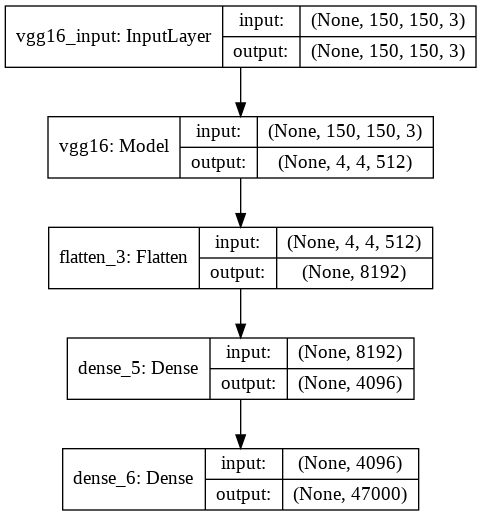

In [0]:
import keras
keras.utils.plot_model(model, show_shapes=True, to_file='./model_nn_base.png')

In [0]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [0]:
# model training 
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=10
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='model/model_47000img_identification.h5',
        monitor='val_sparse_categorical_accuracy',
        save_best_only=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3
    )
]
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['sparse_categorical_accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=100,
    validation_data=test_generator,
    validation_steps=STEP_SIZE_TRAIN,
    callbacks=callbacks_list)

In [0]:
# load saved model
model = load_model("model/model_47000img_identification.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [0]:
# model evaluation on 47k images
model.evaluate_generator(test_generator, STEP_SIZE_TEST, verbose=1)

1468/1468 [==============================] - 255s 174ms/step


[0.047543495893478394, 0.9682177901268005]

In [0]:
# one test case
final_test_X = np.expand_dims(X[6000], axis=0)/255.0

In [0]:
final_test_X.shape

(1, 150, 150, 3)

In [0]:
tmp = model.predict(final_test_X, verbose=1)

1/1 [==============================] - 0s 31ms/step


In [0]:
np.argmax(tmp)

6000

In [0]:
fnames= './product_imgs'

In [0]:
from keras.preprocessing import image
import os
import numpy as np

In [0]:
img = image.load_img(os.path.join(fnames,'1886846758.jpg'), target_size=(150, 150))

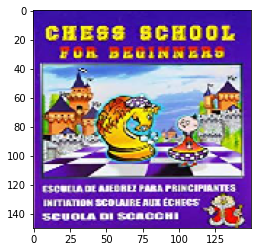

In [0]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [0]:
x = image.img_to_array(img)
final_test_X = np.expand_dims(x, axis=0)/255.0

In [0]:
final_test_X.shape

(1, 150, 150, 3)

In [0]:
tmp = model.predict(final_test_X)
np.argmax(tmp)

21550

In [0]:
# top 3 index
tmp = tmp.flatten()
top_3_idx = tmp.argsort()[::-1][:3]
top_3_items = {idx2label[i]:np.round(tmp[i],10) for i in top_3_idx}
top_3_items

{'1886846758': 1.0, 'B002NECK0E': 2.9e-09, 'B002O7HFDC': 0.0}